In [2]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot

!pip install git+https://github.com/mps-youtube/pafy.git#egg=pafy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.1 MB/s eta 0:00:00
  Cloning https://github.com/mps-youtube/pafy.git to /tmp/pip-install-hf0fxikc/pafy_d933b53618c44729a5f9a77c55cfae41
  Running command git clone --filter=blob:none --quiet https://github.com/mps-youtube/pafy.git /tmp/pip-install-hf0fxikc/pafy_d933b53618c44729a5f9a77c55cfae41
  Resolved https://github.com/mps-youtube/pafy.git to commit 0580c7247e74f4caa97154ad4fd6763e991198f8
  Preparing metadata (setup.py) ... done
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35695 sha256=6ada9b1c402734d8d4720bec0ac81865786e92c9a13c38140cd7daaca8e3c3a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_9k52ri/wheels/24/3e/c9/451ef7befb9193b3c6af0917d6f5ab9cd4ba72bbf544b22b73
Successfully built pafy


In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:

!wget --no-check-certificate  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar

--2023-09-10 06:52:07--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2023-09-10 06:52:08--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  59.3MB/s    in 26s     

2023-09-10 06:52:34 (76.7 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]



In [6]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [7]:
!unrar x hmdb51_org.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from hmdb51_org.rar

Extracting  shoot_gun.rar                                                  0%  1%  OK 
Extracting  sit.rar                                                        1%  2%  3%  OK 
Extracting  situp.rar                                                      3%  4%  OK 
Extracting  smile.rar                                                      4%  5%  OK 
Extracting  smoke.rar                                                      5%  6%  7%  OK 
Extracting  somersault.rar                                                 7%  8%  9%  OK 
Extracting  stand.rar                                                      9% 10% 11%  OK 
Extracting  swing_baseball.rar                                            11% 12% 13%  OK 
Extracting  sword.rar                               

In [8]:
!unrar x drink.rar
!unrar x eat.rar
!unrar x fall_floor.rar
!unrar x run.rar
!unrar x sit.rar
!unrar x stand.rar
# !unrar x situp.rar
!unrar x walk.rar
# !unrar x jump.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from drink.rar

Creating    drink                                                     OK
Extracting  drink/20060723sfjffsomelikeitwarmed_drink_f_nm_np1_fr_med_5.avi       0%  OK 
Extracting  drink/21_drink_u_nm_np1_fr_goo_9.avi                           0%  OK 
Extracting  drink/310ToYuma_drink_h_cm_np1_le_goo_3.avi                    0%  1%  OK 
Extracting  drink/310ToYuma_drink_h_nm_np1_fr_goo_2.avi                    1%  2%  OK 
Extracting  drink/310ToYuma_drink_u_nm_np1_le_goo_5.avi                    2%  3%  OK 
Extracting  drink/50_FIRST_DATES_drink_u_nm_np1_fr_goo_29.avi              3%  OK 
Extracting  drink/AboutABoy_drink_u_nm_np1_fr_goo_8.avi                    3%  4%  OK 
Extracting  drink/AllThePresidentMen_drink_f_nm_np1_ri_med_8.avi           4%  5%  OK 
Extracting  drink/AllThePresidentMen_drin

In [9]:
import shutil

In [10]:
os.makedirs('hmdb51_org')

In [11]:
lis = ['drink', 'eat', 'fall_floor', 'run','sit','stand','walk']
for i in lis:
    shutil.move('./'+i,'./hmdb51_org')

In [12]:
dir_name = "./"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".rar"):
        os.remove(os.path.join(dir_name, item))

RushHour2_walk_f_nm_np1_fr_med_10.avi
BLACK_HAWK_DOWN_fall_floor_u_cm_np1_fr_med_0.avi
Crash_sit_u_cm_np1_ri_med_22.avi
Shadow_of_a_Doubt_stand_u_cm_np1_fr_med_4.avi
The_Matrix_3_run_f_cm_np1_ri_med_7.avi
Shadow_of_a_Doubt_drink_h_nm_np1_fr_goo_8.avi
Return_of_the_King_5_eat_h_nm_np1_le_goo_8.avi


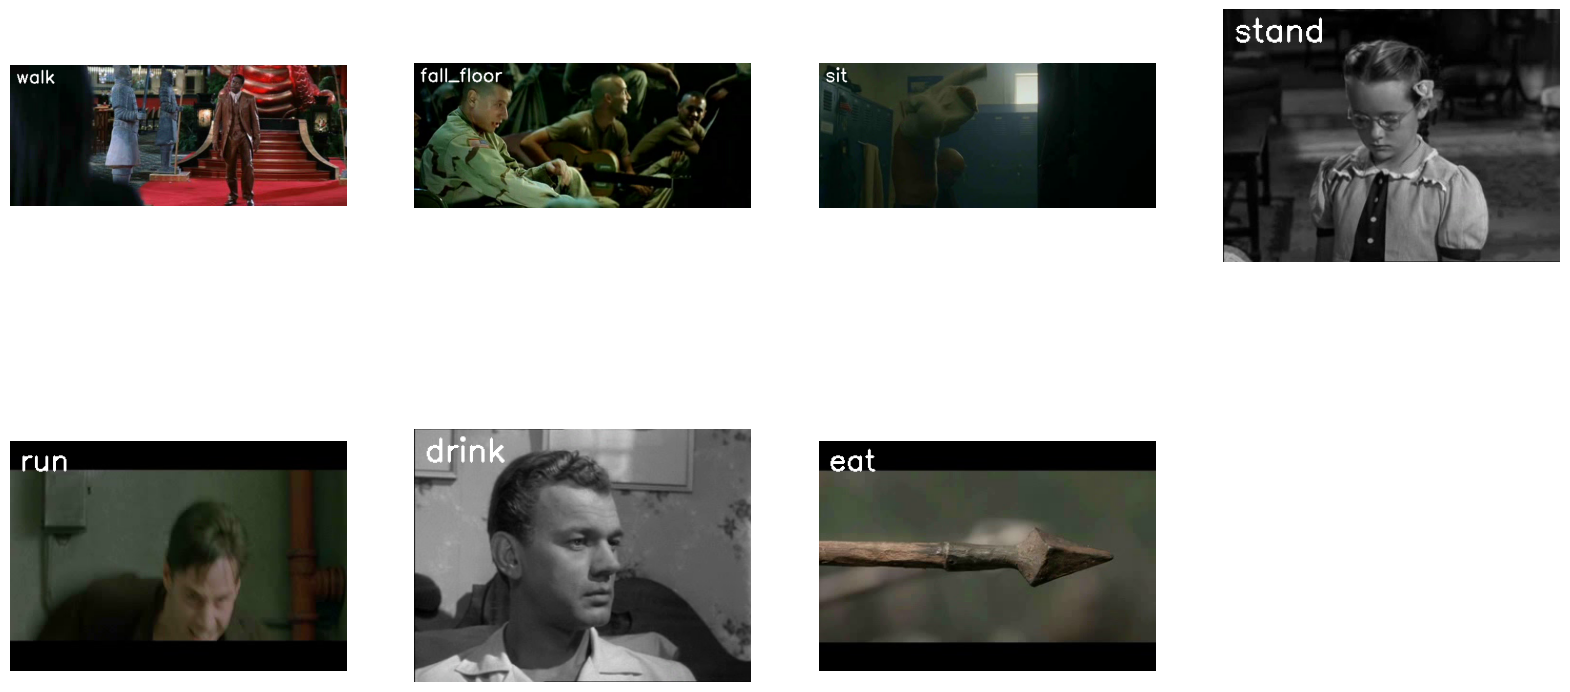

In [13]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 10))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('./hmdb51_org/')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
# random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter in range(len(lis)):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[counter]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'./hmdb51_org/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    print(selected_video_file_name)
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'./hmdb51_org/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(2, 4, counter+1);plt.imshow(rgb_frame);plt.axis('off')

In [14]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "./hmdb51_org/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = lis

In [15]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [16]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [17]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: drink
Extracting Data of Class: eat
Extracting Data of Class: fall_floor
Extracting Data of Class: run
Extracting Data of Class: sit
Extracting Data of Class: stand
Extracting Data of Class: walk


In [18]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [19]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

In [20]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [21]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

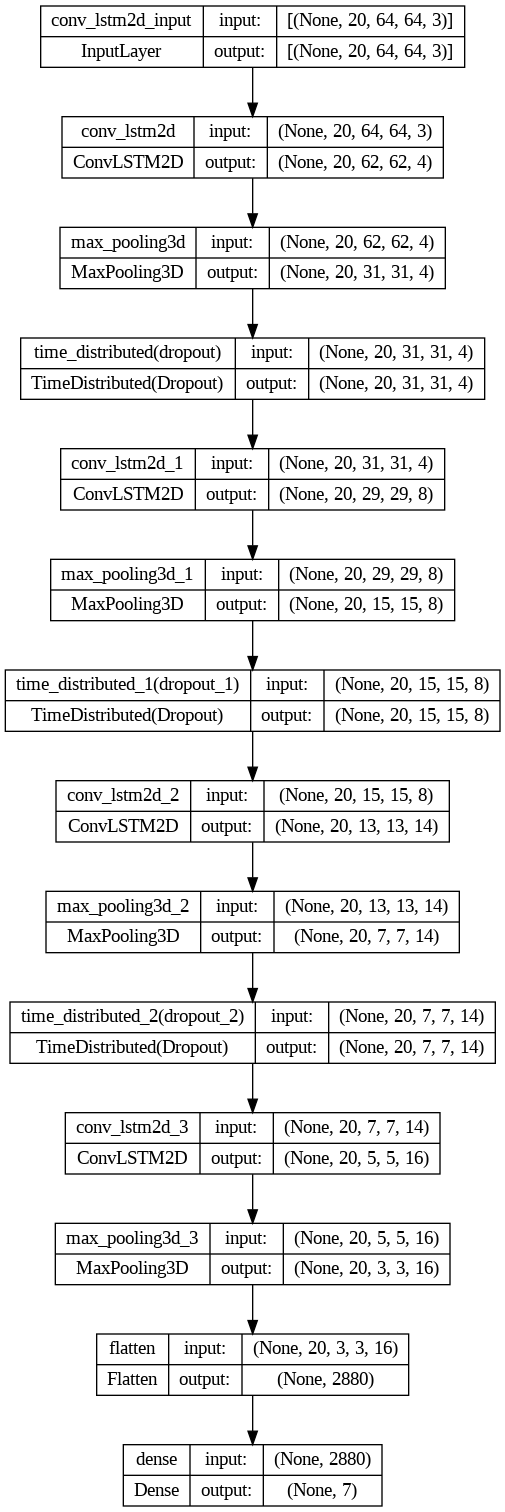

In [23]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 5, batch_size = 8,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

In [1]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

NameError: ignored

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')